In [ ]:
!cd ../yolov3 && git checkout ./

### 引用yolov3

In [ ]:
import sys
sys.path.append("../yolov3")

### select device

In [ ]:
from utils.torch_utils import select_device    
device = select_device('cpu')     
device 

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv3 🚀 v9.6.0-17-g3508a98 torch 1.11.0+cu102 CPU



device(type='cpu')

### Model

In [ ]:
import torch
ckpt = torch.load('../yolov3/yolov3.pt', map_location=device)
print(type(ckpt))
print(ckpt.keys())

<class 'dict'>
dict_keys(['epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'wandb_id', 'date'])


In [ ]:
from models.yolo import Model
m = Model('/work/yolov3/models/yolov3.yaml', ch=3, nc=80, anchors=None).to(device)
m.load_state_dict(ckpt['model'].float().state_dict())
m_m_f = m.fuse().eval()
print(type(m_m_f))


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     20672  models.common.Bottleneck                [64, 64]                      
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    164608  models.common.Bottleneck                [128, 128]                    
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  8   2627584  models.common.Bottleneck                [256, 256]                    
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  8  10498048  

In [ ]:
import time
import torchvision

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def non_max_suppression(prediction, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False, multi_label=False,
                        labels=(), max_det=300):
    """Runs Non-Maximum Suppression (NMS) on inference results

    Returns:
         list of detections, on (n,6) tensor per image [xyxy, conf, cls]
    """

    nc = prediction.shape[2] - 5  # number of classes
    xc = prediction[..., 4] > conf_thres  # candidates

    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

    # Settings
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
    max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
    time_limit = 10.0  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
        x = x[xc[xi]]  # confidence

        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            l = labels[xi]
            v = torch.zeros((len(l), nc + 5), device=x.device)
            v[:, :4] = l[:, 1:5]  # box
            v[:, 4] = 1.0  # conf
            v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
        else:  # best class only
            conf, j = x[:, 5:].max(1, keepdim=True)
            x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Apply finite constraint
        # if not torch.isfinite(x).all():
        #     x = x[torch.isfinite(x).all(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        elif n > max_nms:  # excess boxes
            x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        if i.shape[0] > max_det:  # limit detections
            i = i[:max_det]
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy

        output[xi] = x[i]
        if (time.time() - t) > time_limit:
            print(f'WARNING: NMS time limit {time_limit}s exceeded')
            break  # time limit exceeded

    return output

### show

7


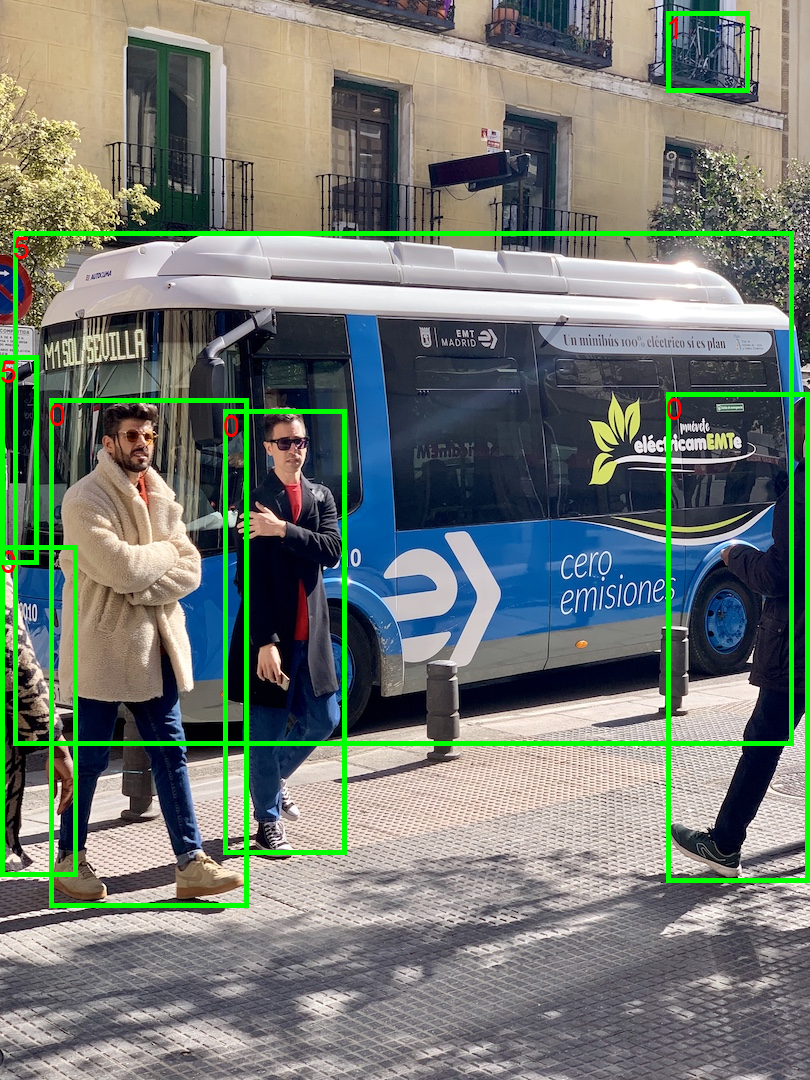

In [ ]:
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.truetype("/root/.config/Ultralytics/Arial.ttf", 30)
image = Image.open("/work/yolov3/data/images/bus.jpg")
draw = ImageDraw.Draw(image)
w = 640 if image.width > image.height else int(image.width * 640 / image.height) 
h = 640 if image.height > image.width else int(image.height * 640 / image.width) 
img = np.asarray(image.resize((w, h)))
img = img.transpose((2, 0, 1))
img = np.ascontiguousarray(img)
im = torch.from_numpy(img).to(device)
im = im.float()
im /= 255 
im = im[None]
pred = m_m_f(im, augment=False, visualize=False)[0]
pred = non_max_suppression(pred, 0.25, 0.45, None, False, max_det=1000)
print(len(pred[0]))
for i, det in enumerate(pred):
    if len(det):
        for *xyxy, conf, cls in det:
            x1 = int(xyxy[0] * image.width / w)
            y1 = int(xyxy[1] * image.height / h)
            x2 = int(xyxy[2] * image.width / w)
            y2 = int(xyxy[3] * image.height / h)
            draw.rectangle([x1,y1,x2,y2],outline=(0,255,0),width=5)
            draw.text((x1,y1),m_m_f.names[int(cls)],font=font,fill=(255,0,0))
image.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4c27263b-a773-4b36-bc5c-6cb959f3ea6f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>